In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Settings for graphs
sns.set_theme()
sns.set(rc={'figure.figsize':(16,10)}, style='white')
plt.figure(dpi=600)
sns.set_palette("Set2")

# Definitions
N_SEEDS = 5
SEEDS = [f"S{i}" for i in range(1, N_SEEDS+1)]

CURRICULUMS = [
    'standard',
    '01111',
    '01110',
    '11110',
    'systematic'
]
ENVIRONMENTS = [
    'continuous',
    'discrete'
]

BASE_DIR = '../../evorobot-paper/data/experiments'

<Figure size 9600x6000 with 0 Axes>

In [2]:
def stats_obj(
    seed,
    stats,
    stats_index,
    curriculum,
    environment
):
    steps, bestfit, bestgfit, avgfit = stats[stats_index:stats_index+4]
    generation = int((stats_index + 6) / 6)
    position = CURRICULUMS.index(curriculum)
    return dict(
        dict(
            id=f"{environment}-{curriculum}-{seed}",
            steps=steps,
            bestfit=bestfit,
            bestgfit=bestgfit,
            avgfit=avgfit,
            generation=generation,
            curriculum=curriculum,
            environment=environment,
            seed=seed,
            position=position
        )
    )

def critic_obj(
    seed,
    metrics,
    generation,
    curriculum,
    environment
):
    position = CURRICULUMS.index(curriculum)
    return dict(
        generation=generation,
        curriculum=curriculum,
        environment=environment,
        seed=seed,
        position=position,
        **metrics
    )

def summary_obj(
    seed,
    stats,
    cpu_time,
    curriculum,
    environment,
    critic=None
):
    stats_df = pd.DataFrame(stats)
    bestgfit = stats_df.bestgfit.max()
    avgfit = stats_df.avgfit.mean()

    if critic:
        critic_df = pd.DataFrame(critic)
        active_time = sum([
            1 if acc > 0.75 else 0 for acc in list(critic_df.accuracy)
        ]) / stats_df.generation.max()
    else:
        active_time = 1

    position = CURRICULUMS.index(curriculum)
    return dict(
        seed=seed,
        performance=bestgfit,
        avg_fitness=avgfit,
        cpu_time=cpu_time,
        active_time=active_time,
        curriculum=curriculum,
        environment=environment,
        position=position
    )

def read_stats(file_path, seed):
    stats_path = f"{file_path}/stat{seed}.npy"
    return np.load(stats_path)

def read_critic(file_path, seed):
    critic_path = f"{file_path}/critic{seed}.npy"
    raw = np.load(critic_path, allow_pickle=True)
    return raw.item()

def read_curriculum(file_path, seed):
    curriculum_path = f"{file_path}/curriculum{seed}.npy"
    return np.load(curriculum_path)

def read_cpu_time(file_path, seed):
    with open(f"{file_path}/{seed}.fit", 'r') as f:
        sf = f.readlines()
        return float(sf[0].split('runtime ')[1])


In [3]:
stats_data, critic_data, curriculum_data, summary_data = [], [], [], []

for environment in ENVIRONMENTS:
    for curriculum in CURRICULUMS:
        for seed in SEEDS:

            seed_critic = None
            if curriculum not in ['systematic', 'standard']:
                file_path = f"{BASE_DIR}/critic-curriculum/distributions/{environment}/{curriculum}"
                
                critic_raw = read_critic(file_path, seed)
                seed_critic = [
                    critic_obj(
                        seed,
                        metrics,
                        generation,
                        curriculum,
                        environment
                    ) for generation, metrics in critic_raw.items()
                ]
                critic_data += seed_critic

            elif curriculum == 'standard':
                file_path = f"{BASE_DIR}/standard/{environment}"
            elif curriculum == 'systematic' and environment == 'discrete':
                file_path = f"{BASE_DIR}/systematic-curriculum"
            else:
                continue

            stats = read_stats(file_path, seed)
            cpu_time = read_cpu_time(file_path, seed)

            seed_stats = [
                stats_obj(
                    seed,
                    stats,
                    idx,
                    curriculum,
                    environment
                ) for idx in range(0, len(stats), 6)
            ]
            stats_data += seed_stats

            summary_stats = summary_obj(
                seed,
                seed_stats,
                cpu_time,
                curriculum,
                environment,
                seed_critic
            )
            summary_data.append(summary_stats)


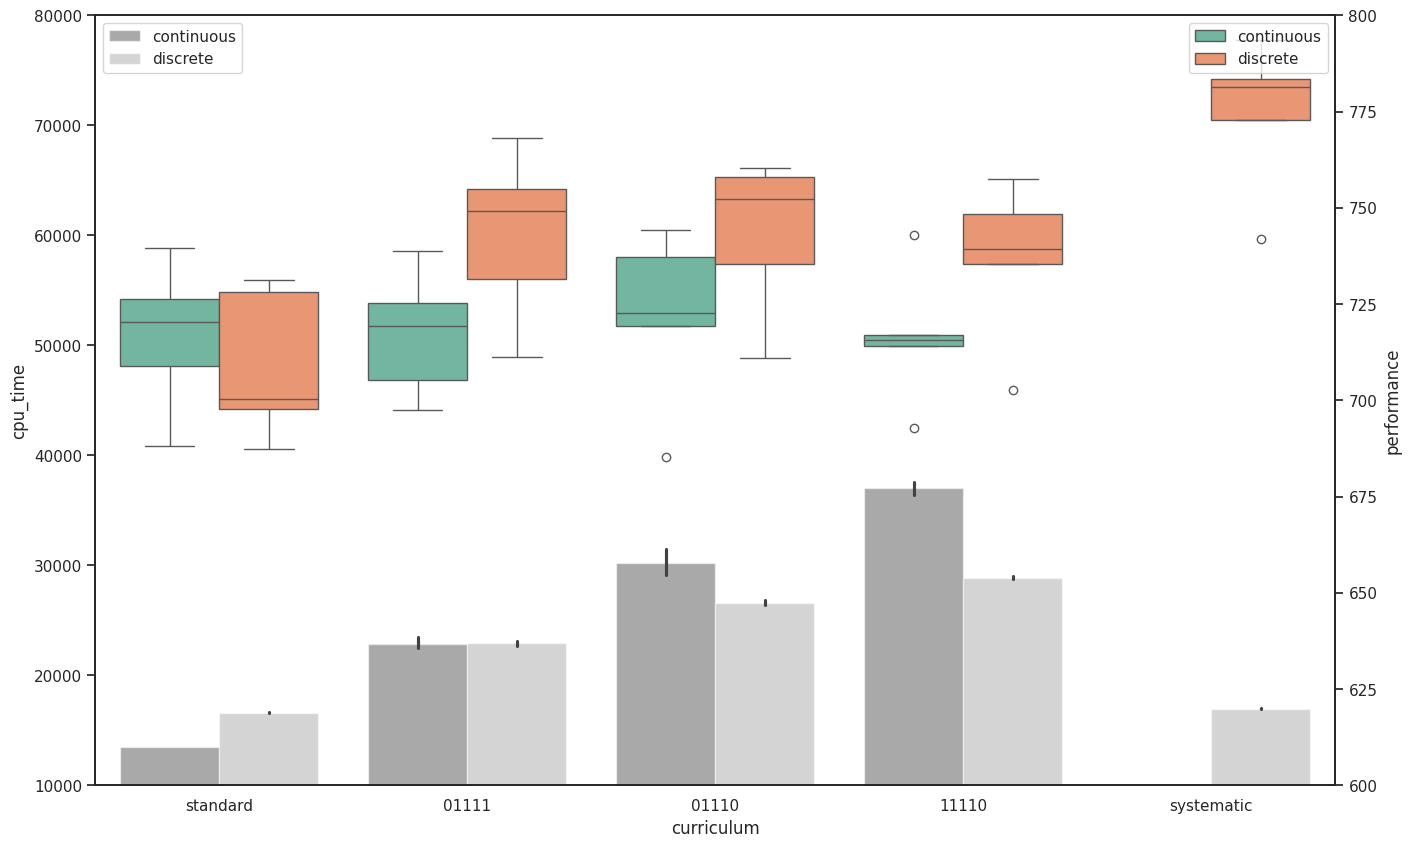

In [8]:
summary_df = pd.DataFrame(summary_data)

sns.barplot(summary_df, x='curriculum', y='cpu_time', hue="environment", palette="gray", alpha=0.5)
plt.ylim([10000, 80000])
plt.legend(loc='upper left')
ax2 = plt.twinx()
sns.boxplot(summary_df, x='curriculum', y='performance', hue='environment', ax=ax2)
ax2.set_ylim([600, 800])
ax2.legend(loc='upper right')


(0.0, 800.0)

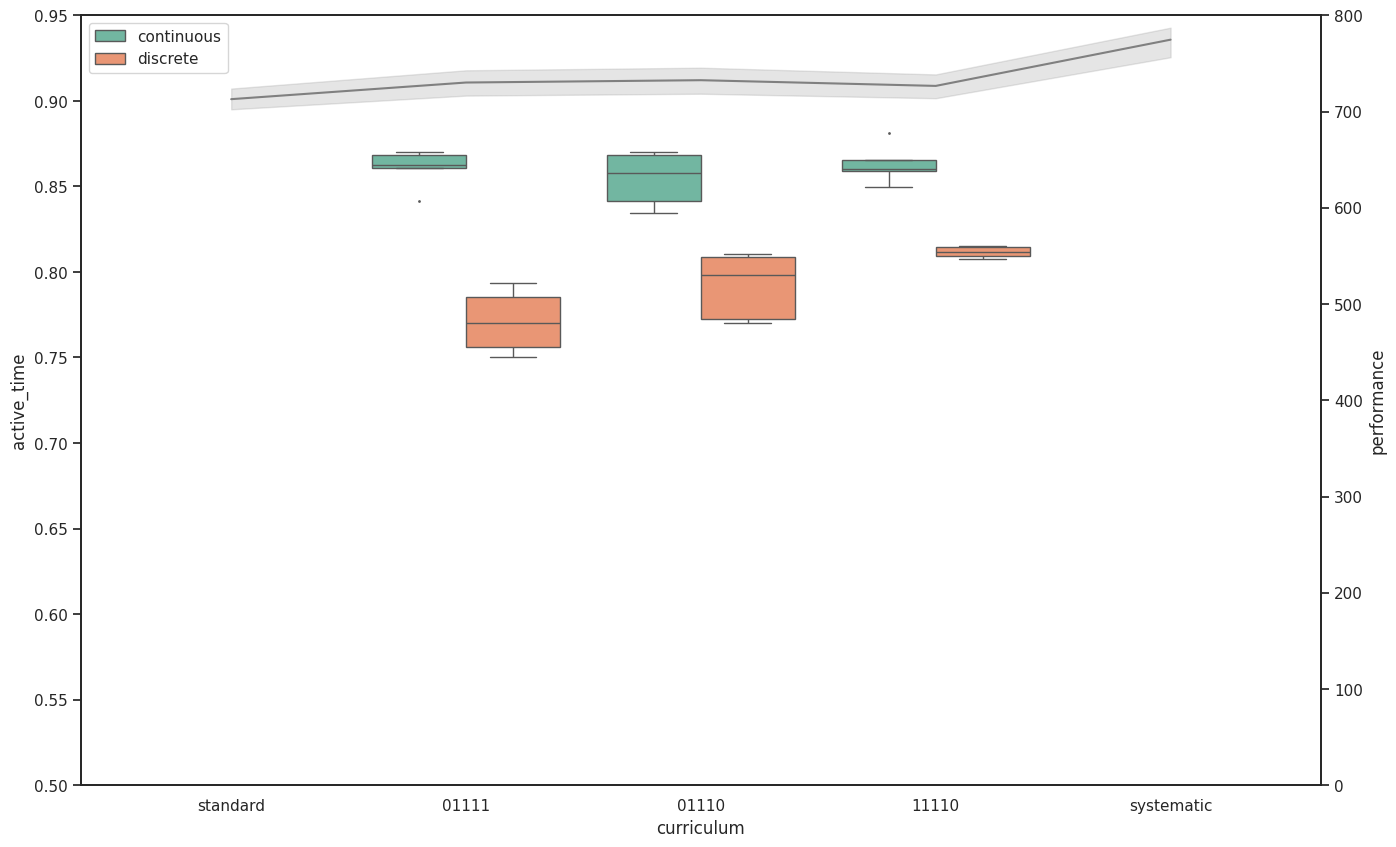

In [16]:
sns.boxplot(data=summary_df, x='curriculum', y='active_time', hue='environment', fliersize=1)
plt.legend(loc='upper left')
plt.ylim([0.5, 0.95])
ax2 = plt.twinx()
sns.lineplot(summary_df, x='curriculum', y='performance', markers=True, color='gray', ax=ax2)
ax2.set_ylim([0, 800])